**Introduction**

The goal is to predict booking counts for station `4818.03` over the next 90 days (January-March 2025) using historical trip data, temporal features, and urban surroundings.


In [112]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


**Data Preparation**

In [62]:
# Import Libraries
import pandas as pd
import numpy as np

# -------------------- Load Citi Bike Daily Data (2021–2024) --------------------
df_2021 = pd.read_csv("/content/2021Citibike daily trip counts&weather.csv", dtype={'start_station_id': str})
df_2022 = pd.read_csv("/content/2022Citibike daily trip counts&weather.csv", dtype={'start_station_id': str})
df_2023 = pd.read_csv("/content/2023Citibike daily trip counts&weather.csv", dtype={'start_station_id': str})
df_2024 = pd.read_csv("/content/2024Citibike daily trip counts&weather.csv", dtype={'start_station_id': str})

# Combine into one dataset
df_all = pd.concat([df_2021, df_2022, df_2023, df_2024], ignore_index=True)

# Clean and rename columns
df_all.rename(columns={"DATE": "ds", "booking_count": "y", "TAVG": "temperature"}, inplace=True)
df_all['ds'] = pd.to_datetime(df_all['ds'], errors='coerce')
df_all.dropna(subset=["ds", "y"], inplace=True)
df_all['start_station_id'] = df_all['start_station_id'].astype(str)

# Add time-based features
df_all['day_of_week'] = df_all['ds'].dt.dayofweek
df_all['is_weekend'] = df_all['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Summary
print("Full dataset loaded and preprocessed")
print("Unique stations:", df_all['start_station_id'].nunique())
print("Shape:", df_all.shape)
df_all.head()


Full dataset loaded and preprocessed
Unique stations: 879
Shape: (855230, 6)


,start_station_id,ds,y,temperature,day_of_week,is_weekend
0,4818.03,2021-01-01,4.0,36.5,4,0
1,4818.03,2021-01-02,16.0,43.5,5,1
2,4818.03,2021-01-03,5.0,36.0,6,1
3,4818.03,2021-01-04,8.0,39.0,0,0
4,4818.03,2021-01-05,8.0,39.0,1,0


In [64]:
urban_features = pd.read_csv("/content/Final_Urban_Features_Merged.csv")
urban_features.head()

,station_id,metro_500m,bus_500m,Parks_500m,Libraries_500m,Colleges_500m,Attractions_500m,Athletics_500m,Supermarkets and Convenience Stores_500m,Malls and Shopping Centers_500m,"Restaurants, Cafes, and Bars_500m",Retail Stores_500m,hospitals_500m,residential_500m,civic_buildings_500m,event_venues_500m,start_lat,start_lng
0,4818.03,8,13,0,0,0,0,0,1,0,0,0,0,0,1,0,40.700295,-73.950323
1,4821.03,6,21,0,0,0,0,0,6,0,30,5,0,0,0,1,40.700119,-73.986200
2,4821.1,6,20,0,0,0,0,0,6,0,44,5,0,0,0,1,40.700763,-73.988698
3,4829.01,5,0,0,0,0,1,0,1,0,19,0,1,0,0,0,40.700379,-73.995481
4,4832.07,3,23,0,0,0,0,0,7,0,50,6,0,0,3,2,40.701120,-73.930390


In [65]:
urban_features.columns

Index(['station_id', 'metro_500m', 'bus_500m', 'Parks_500m', 'Libraries_500m',
       'Colleges_500m', 'Attractions_500m', 'Athletics_500m',
       'Supermarkets and Convenience Stores_500m',
       'Malls and Shopping Centers_500m', 'Restaurants, Cafes, and Bars_500m',
       'Retail Stores_500m', 'hospitals_500m', 'residential_500m',
       'civic_buildings_500m', 'event_venues_500m', 'start_lat', 'start_lng'],
      dtype='object')

In [108]:
# Step 1: Normalize and convert IDs to string for safe merging
df_all['start_station_id'] = df_all['start_station_id'].astype(str).str.strip()
urban_features['station_id'] = urban_features['station_id'].astype(str).str.strip()

# Step 2: Merge on station ID
df_combined = df_all.merge(urban_features, left_on='start_station_id', right_on='station_id', how='left')

# Step 3: Drop redundant column
df_combined.drop(columns=['station_id'], inplace=True)

# Result: combined time series + static context
print("Merged shape:", df_combined.shape)
df_combined.head()


Merged shape: (1778998, 23)


,start_station_id,ds,y,temperature,day_of_week,is_weekend,metro_500m,bus_500m,Parks_500m,Libraries_500m,...,Supermarkets and Convenience Stores_500m,Malls and Shopping Centers_500m,"Restaurants, Cafes, and Bars_500m",Retail Stores_500m,hospitals_500m,residential_500m,civic_buildings_500m,event_venues_500m,start_lat,start_lng
0,4818.03,2021-01-01,4.0,36.5,4,0,8,13,0,0,...,1,0,0,0,0,0,1,0,40.700295,-73.950323
1,4818.03,2021-01-01,4.0,36.5,4,0,8,13,0,0,...,1,0,0,0,0,0,1,0,40.700295,-73.950323
2,4818.03,2021-01-02,16.0,43.5,5,1,8,13,0,0,...,1,0,0,0,0,0,1,0,40.700295,-73.950323
3,4818.03,2021-01-02,16.0,43.5,5,1,8,13,0,0,...,1,0,0,0,0,0,1,0,40.700295,-73.950323
4,4818.03,2021-01-03,5.0,36.0,6,1,8,13,0,0,...,1,0,0,0,0,0,1,0,40.700295,-73.950323


In [78]:
df_combined.columns

Index(['start_station_id', 'ds', 'y', 'temperature', 'day_of_week',
       'is_weekend', 'metro_500m', 'bus_500m', 'Parks_500m', 'Libraries_500m',
       'Colleges_500m', 'Attractions_500m', 'Athletics_500m',
       'Supermarkets and Convenience Stores_500m',
       'Malls and Shopping Centers_500m', 'Restaurants, Cafes, and Bars_500m',
       'Retail Stores_500m', 'hospitals_500m', 'residential_500m',
       'civic_buildings_500m', 'event_venues_500m', 'start_lat', 'start_lng'],
      dtype='object')

In [76]:
display(df_combined['start_station_id'].nunique())


879

In [93]:
station_id = '4818.03'
df_combined['start_station_id'] = df_combined['start_station_id'].astype(str).str.strip()
df_station = df_combined[df_combined['start_station_id'] == station_id].copy()

# Ensure datetime
df_station['ds'] = pd.to_datetime(df_station['ds'])
df_station = df_station.sort_values("ds")


**Outlier removal**

In [94]:
Q1 = df_station['y'].quantile(0.25)
Q3 = df_station['y'].quantile(0.75)
IQR = Q3 - Q1

df_station = df_station[
    (df_station['y'] >= Q1 - 1.5 * IQR) &
    (df_station['y'] <= Q3 + 1.5 * IQR)
]


**Feature engineering of time-based columns**

In [144]:
# Date-related temporal features
df_station['day_of_week'] = df_station['ds'].dt.dayofweek
df_station['is_weekend'] = df_station['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_station['month'] = df_station['ds'].dt.month
df_station['weekofyear'] = df_station['ds'].dt.isocalendar().week.astype(int)

# Lag features
df_station['lag_1'] = df_station['y'].shift(1)
df_station['lag_7'] = df_station['y'].shift(7)

# Rolling statistics
df_station['rolling_mean_7'] = df_station['y'].rolling(window=7).mean()
df_station['rolling_std_7'] = df_station['y'].rolling(window=7).std()

# Drop rows with NaN caused by lags/rolling
df_station.dropna(inplace=True)


Reconstructed df_station shape: (2915, 28)


,start_station_id,ds,y,temperature,day_of_week,is_weekend,metro_500m,bus_500m,Parks_500m,Libraries_500m,...,residential_500m,civic_buildings_500m,event_venues_500m,start_lat,start_lng,weekofyear,lag_1,lag_7,rolling_mean_7,rolling_std_7
7,4818.03,2021-01-04,8.0,39.0,0,0,8,13,0,0,...,0,1,0,40.700295,-73.950323,1,8.0,4.0,8.285714,5.437962
8,4818.03,2021-01-05,8.0,39.0,1,0,8,13,0,0,...,0,1,0,40.700295,-73.950323,1,8.0,4.0,8.857143,5.113009
9,4818.03,2021-01-05,8.0,39.0,1,0,8,13,0,0,...,0,1,0,40.700295,-73.950323,1,8.0,16.0,9.428571,4.685337
11,4818.03,2021-01-06,12.0,37.5,2,0,8,13,0,0,...,0,1,0,40.700295,-73.950323,1,8.0,16.0,8.285714,3.683942
10,4818.03,2021-01-06,12.0,37.5,2,0,8,13,0,0,...,0,1,0,40.700295,-73.950323,1,12.0,5.0,7.714286,2.360387


**Exploratory Data Analysis (EDA)**

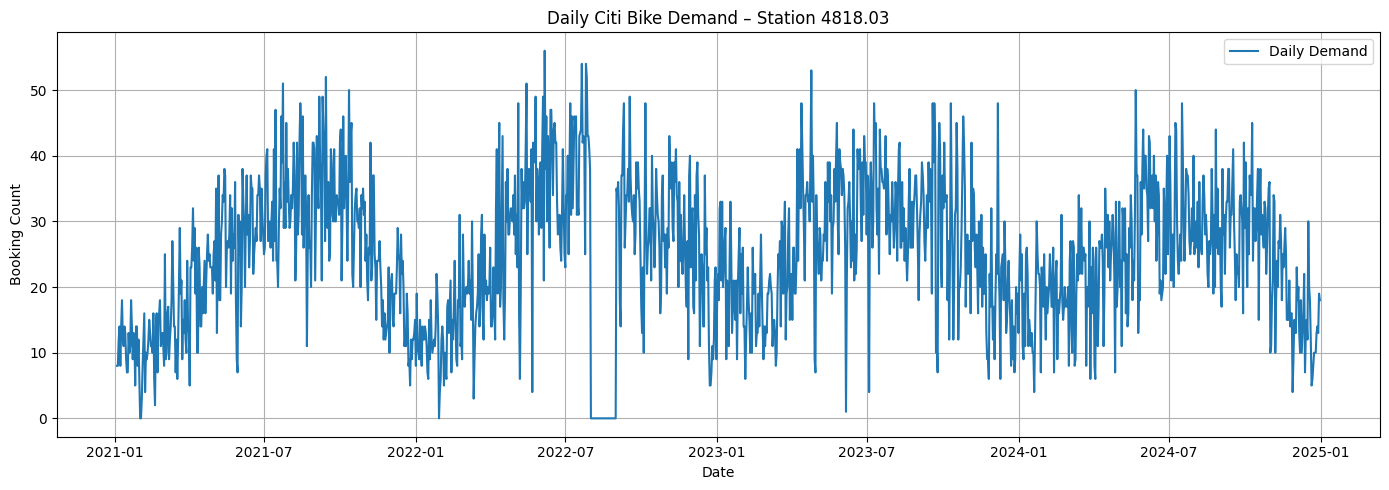

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df_station['ds'], df_station['y'], label='Daily Demand')
plt.title("Daily Citi Bike Demand – Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


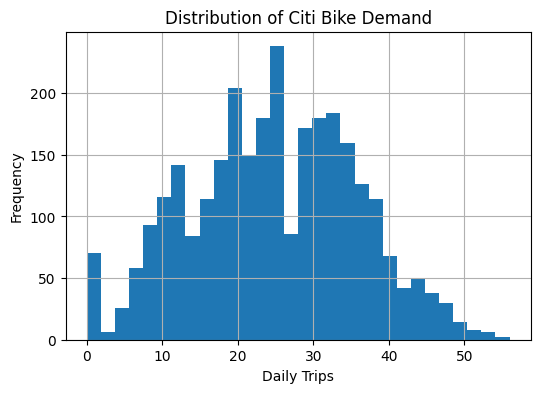

In [97]:
df_station['y'].hist(bins=30, figsize=(6, 4))
plt.title("Distribution of Citi Bike Demand")
plt.xlabel("Daily Trips")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


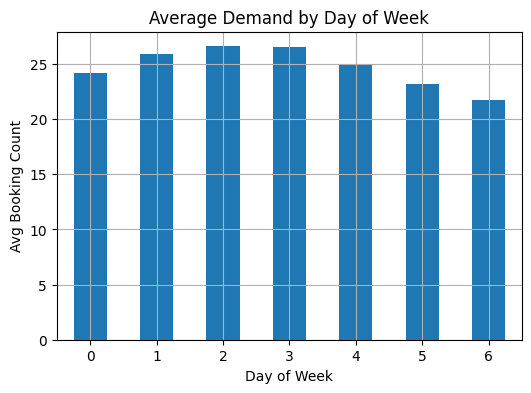

In [98]:
df_station.groupby("day_of_week")['y'].mean().plot(kind='bar', figsize=(6, 4))
plt.title("Average Demand by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Booking Count")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [92]:
missing = df_station.isna().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Series([], dtype: int64)


**Training Models**

**Feature Selection and Splitting** : We train and tune four ensemble models using `GridSearchCV` with 5-fold cross-validation:

In [148]:
df_station = df_station.sort_values('ds')
n = len(df_station)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train = df_station.iloc[:train_end]
val   = df_station.iloc[train_end:val_end]
test  = df_station.iloc[val_end:]

# Step 7: Feature/target split
feature_cols = [col for col in df_station.columns if col not in ['ds', 'y', 'start_station_id']]
X_train, y_train = train[feature_cols], train['y']
X_val, y_val     = val[feature_cols], val['y']
X_test, y_test   = test[feature_cols], test['y']


**RANDOM FOREST**

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

 Model Evaluation Metrics:


,MSE,MAE,RMSE,MAPE (%)
Validation,36.45,4.27,6.04,27.10
Test,31.46,3.93,5.61,18.17


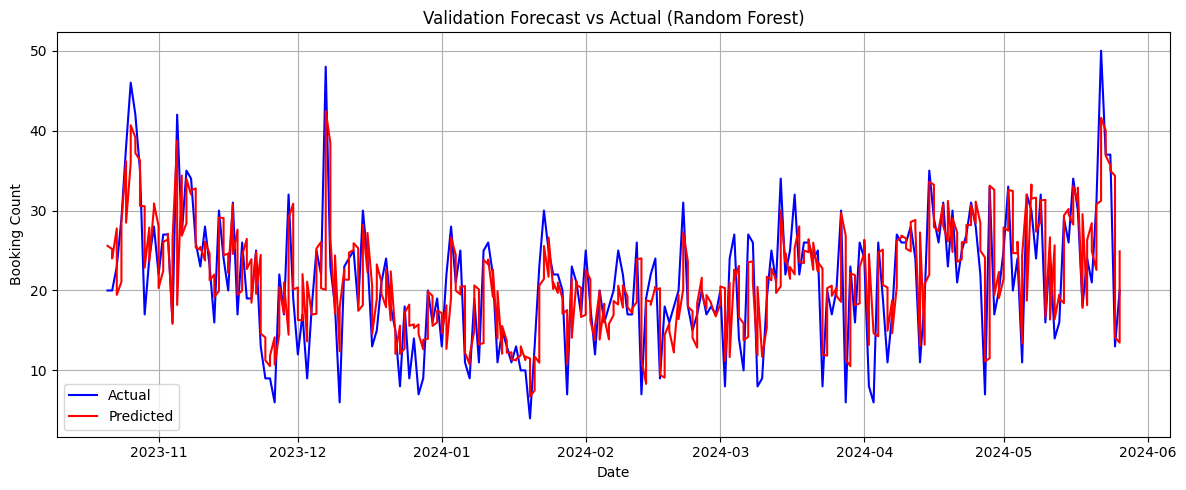

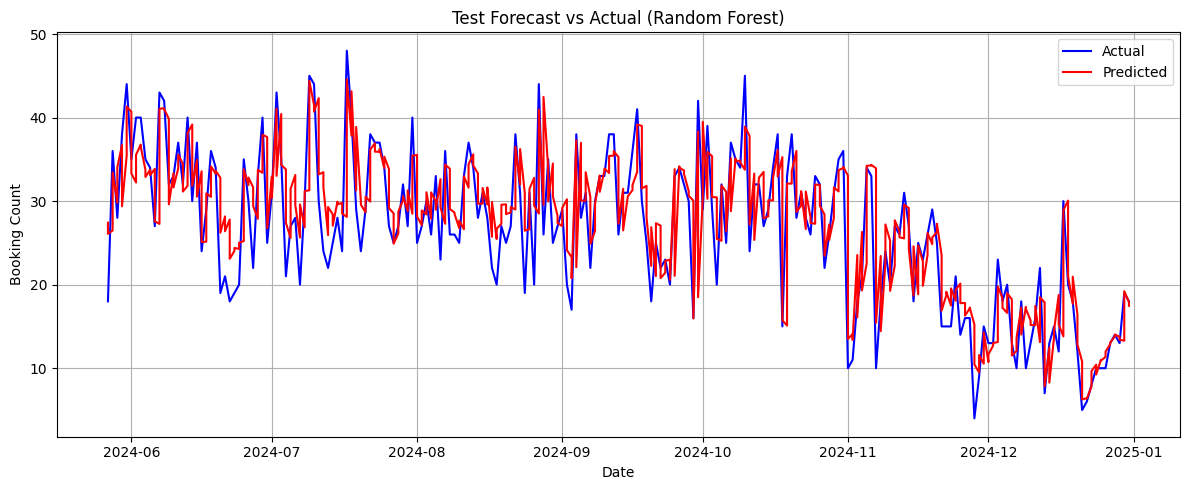

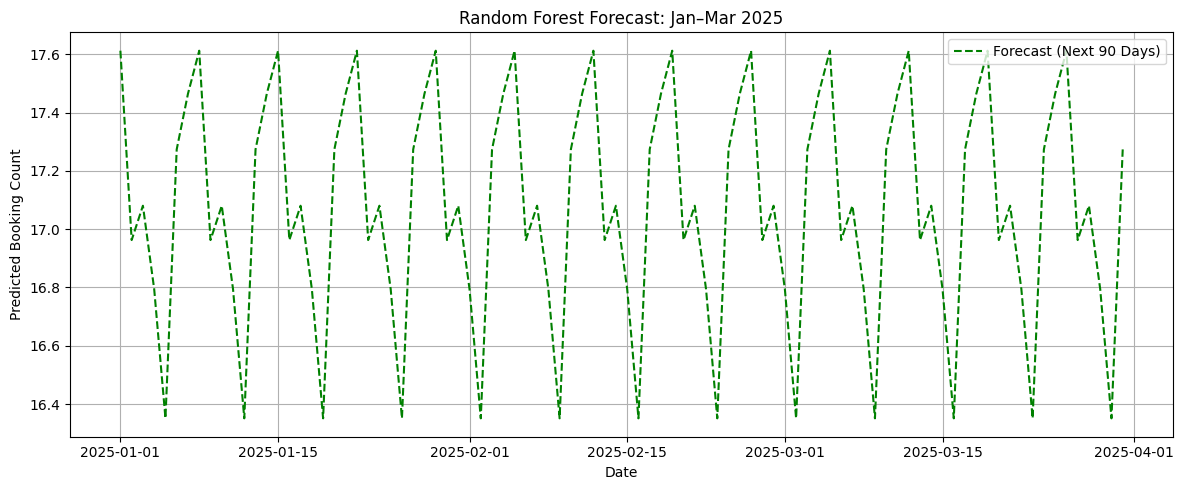

In [188]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Define renaming dictionary for consistency
rename_dict = {
    'Malls and Shopping Centers_500m': 'Malls_and_Shopping_Centers_500m',
    'Restaurants, Cafes, and Bars_500m': 'Restaurants__Cafes__and_Bars_500m',
    'Retail Stores_500m': 'Retail_Stores_500m',
    'Supermarkets and Convenience Stores_500m': 'Supermarkets_and_Convenience_Stores_500m',
}

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Train with grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# Rename features for consistency
X_val = X_val.rename(columns=rename_dict)
X_test = X_test.rename(columns=rename_dict)

# Predict
y_val_pred = best_rf.predict(X_val)
y_test_pred = best_rf.predict(X_test)

# Evaluation function
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mse, mae, rmse, mape

# Compute metrics
mse_val, mae_val, rmse_val, mape_val = compute_metrics(y_val, y_val_pred)
mse_test, mae_test, rmse_test, mape_test = compute_metrics(y_test, y_test_pred)

# Step 1: Clean Table of Metrics
metrics_df = pd.DataFrame({
    'MSE': [mse_val, mse_test],
    'MAE': [mae_val, mae_test],
    'RMSE': [rmse_val, rmse_test],
    'MAPE (%)': [mape_val, mape_test]
}, index=['Validation', 'Test'])

print("\n Model Evaluation Metrics:")
display(metrics_df.round(2))

# Step 2: Validation Plot
plt.figure(figsize=(12, 5))
plt.plot(val['ds'], y_val.values, label='Actual', color='blue')
plt.plot(val['ds'], y_val_pred, label='Predicted', color='red')
plt.title("Validation Forecast vs Actual (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Test Plot
plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_test.values, label='Actual', color='blue')
plt.plot(test['ds'], y_test_pred, label='Predicted', color='red')
plt.title("Test Forecast vs Actual (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Generate 90-day Forecast
last_date = df_station['ds'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90)

last_known_row = df_station.iloc[-1].copy()
future_data_rf = []

for date in future_dates:
    new_row = last_known_row.copy()
    new_row['ds'] = date
    new_row['day_of_week'] = date.weekday()
    new_row['is_weekend'] = int(date.weekday() in [5, 6])
    X_future = pd.DataFrame([new_row])[feature_cols]
    X_future = X_future.rename(columns=rename_dict)
    new_row['y'] = best_rf.predict(X_future)[0]
    future_data_rf.append(new_row)
    last_known_row = new_row.copy()

df_future_rf = pd.DataFrame(future_data_rf)

# Step 5: Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(df_future_rf['ds'], df_future_rf['y'], label="Forecast (Next 90 Days)", linestyle='--', color='green')
plt.title("Random Forest Forecast: Jan–Mar 2025")
plt.xlabel("Date")
plt.ylabel("Predicted Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**XG BOOST**

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 20}

 XGBoost Evaluation Metrics:


,MSE,MAE,RMSE,MAPE (%)
Validation,35.73,4.24,5.98,26.83
Test,31.23,3.97,5.59,18.34


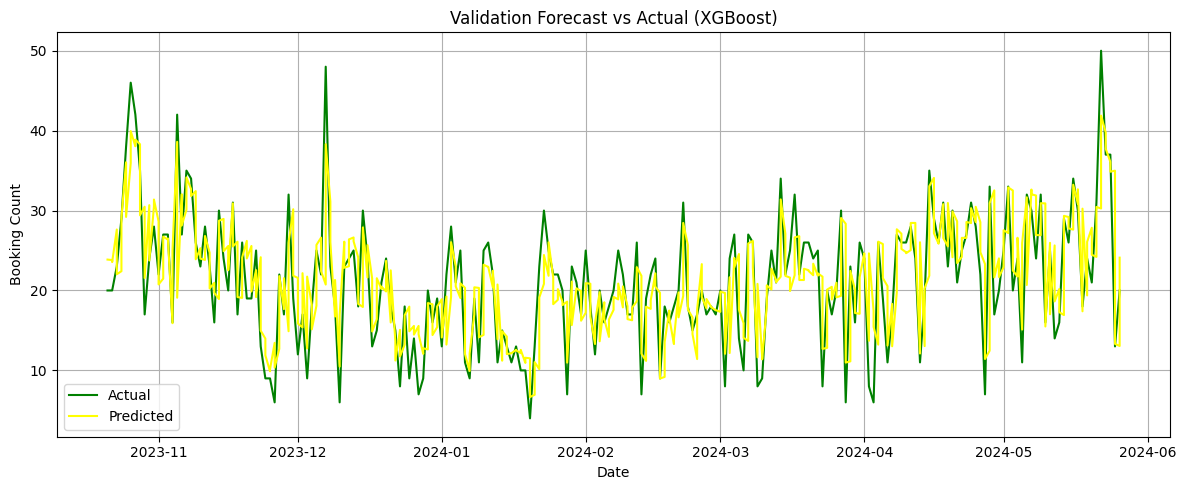

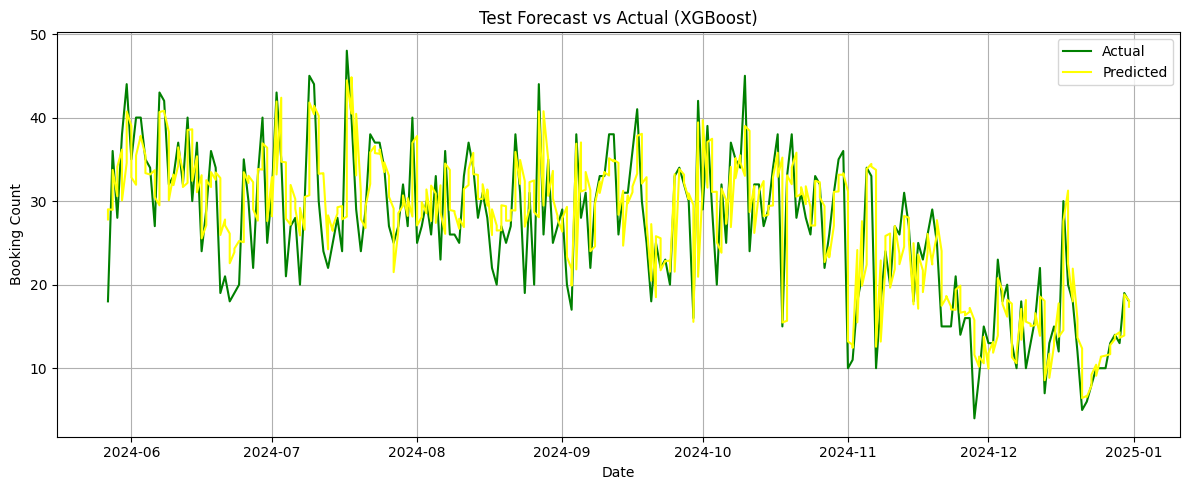

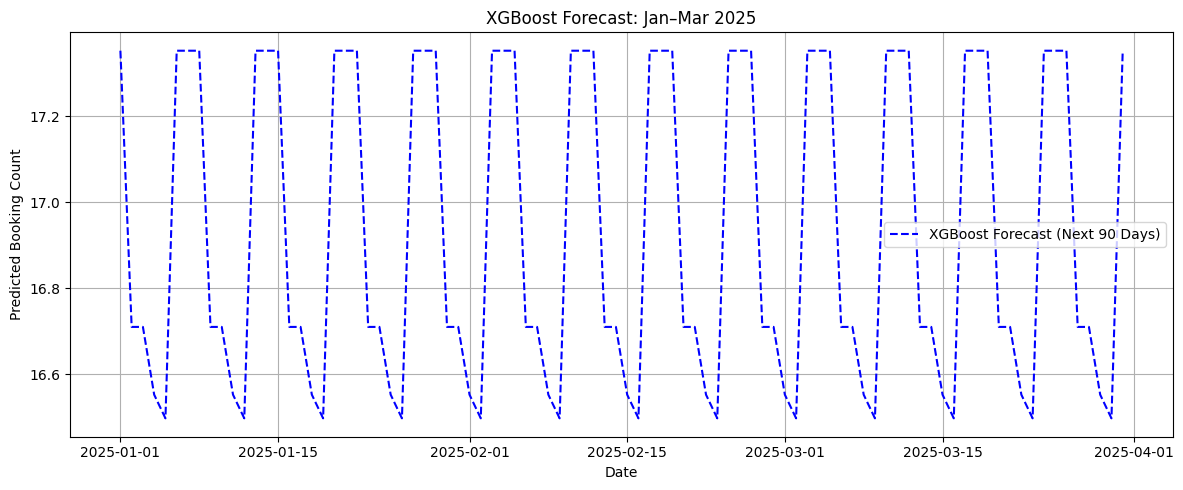

In [205]:
import warnings
warnings.filterwarnings('ignore')

# Step 3: Grid search with XGB
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# Step 4: Fix feature column names for validation/test
X_val = X_val.rename(columns=rename_dict)
X_test = X_test.rename(columns=rename_dict)

# Step 5: Predictions
y_val_pred = best_xgb.predict(X_val)
y_test_pred = best_xgb.predict(X_test)

# Step 6: Evaluation function
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mse, mae, rmse, mape

# Step 7: Calculate and display metrics
mse_val, mae_val, rmse_val, mape_val = compute_metrics(y_val, y_val_pred)
mse_test, mae_test, rmse_test, mape_test = compute_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    'MSE': [mse_val, mse_test],
    'MAE': [mae_val, mae_test],
    'RMSE': [rmse_val, rmse_test],
    'MAPE (%)': [mape_val, mape_test]
}, index=['Validation', 'Test'])

print("\n XGBoost Evaluation Metrics:")
display(metrics_df.round(2))

# Step 8: Validation plot
plt.figure(figsize=(12, 5))
plt.plot(val['ds'], y_val.values, label='Actual', color='green')
plt.plot(val['ds'], y_val_pred, label='Predicted', color='yellow')
plt.title("Validation Forecast vs Actual (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Test plot
plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_test.values, label='Actual', color='green')
plt.plot(test['ds'], y_test_pred, label='Predicted', color='yellow')
plt.title("Test Forecast vs Actual (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Generate 90-day forecast
last_date = df_station['ds'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90)

last_known_row = df_station.iloc[-1].copy()
future_data_xgb = []

for date in future_dates:
    new_row = last_known_row.copy()
    new_row['ds'] = date
    new_row['day_of_week'] = date.weekday()
    new_row['is_weekend'] = int(date.weekday() in [5, 6])

    X_future = pd.DataFrame([new_row])[feature_cols]
    X_future = X_future.rename(columns=rename_dict)
    new_row['y'] = best_xgb.predict(X_future)[0]

    future_data_xgb.append(new_row)
    last_known_row = new_row.copy()

df_future_xgb = pd.DataFrame(future_data_xgb)

# Step 11: Forecast plot
plt.figure(figsize=(12, 5))
plt.plot(df_future_xgb['ds'], df_future_xgb['y'], label="XGBoost Forecast (Next 90 Days)", linestyle='--', color='blue')
plt.title("XGBoost Forecast: Jan–Mar 2025")
plt.xlabel("Date")
plt.ylabel("Predicted Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**CAT BOOST**

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

 CatBoost Evaluation Metrics:


,MSE,MAE,RMSE,MAPE (%)
Validation,37.16,4.27,6.10,27.14
Test,31.23,3.91,5.59,18.15


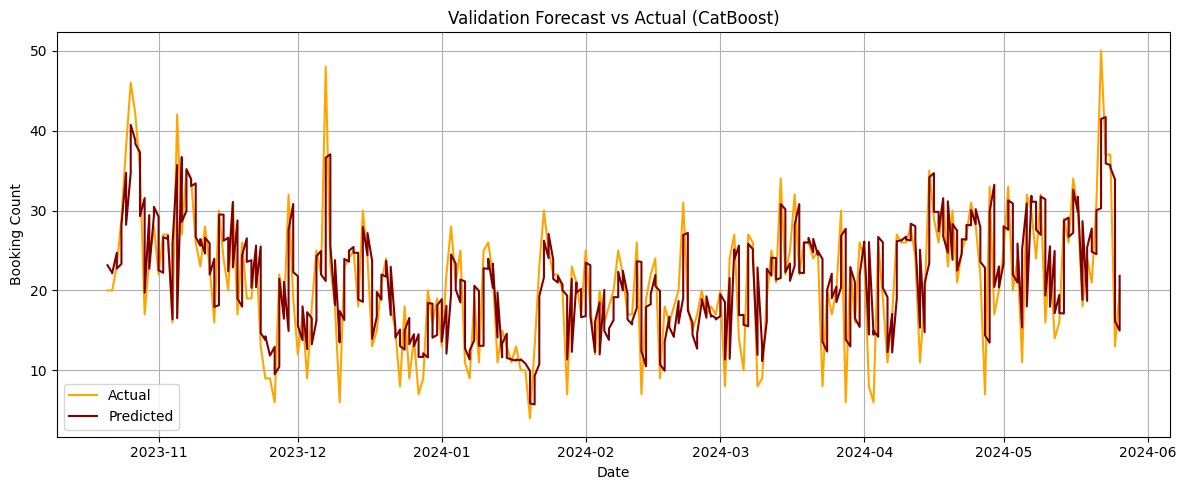

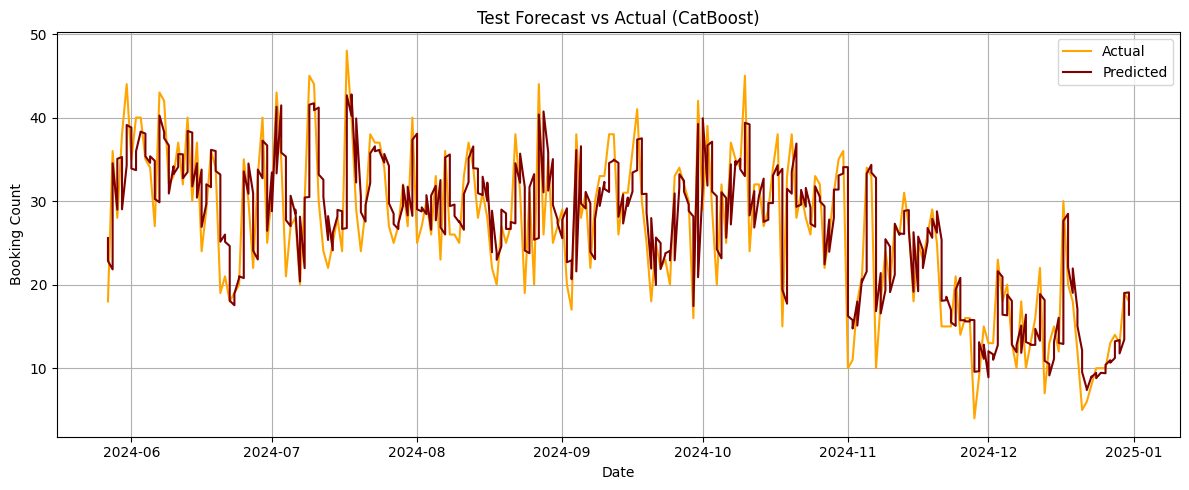

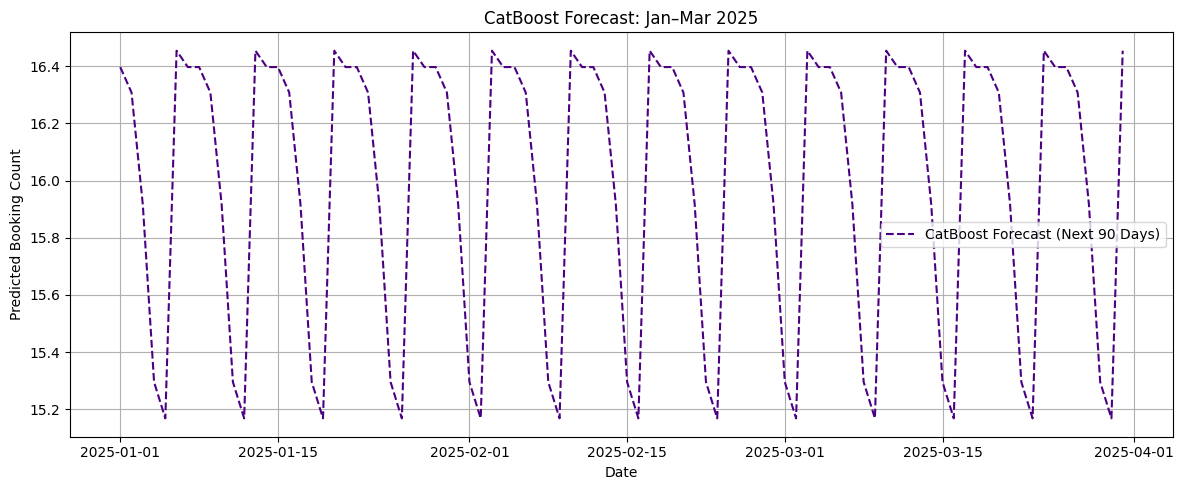

In [192]:
cat = CatBoostRegressor(verbose=0, random_state=42)

# Step 3: Grid search
grid_search = GridSearchCV(cat,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_cat = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# Step 4: Rename validation and test features
X_val = X_val.rename(columns=rename_dict)
X_test = X_test.rename(columns=rename_dict)

# Step 5: Predictions
y_val_pred = best_cat.predict(X_val)
y_test_pred = best_cat.predict(X_test)

# Step 6: Evaluation function
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mse, mae, rmse, mape

# Step 7: Compute and display metrics
mse_val, mae_val, rmse_val, mape_val = compute_metrics(y_val, y_val_pred)
mse_test, mae_test, rmse_test, mape_test = compute_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    'MSE': [mse_val, mse_test],
    'MAE': [mae_val, mae_test],
    'RMSE': [rmse_val, rmse_test],
    'MAPE (%)': [mape_val, mape_test]
}, index=['Validation', 'Test'])

print("\n CatBoost Evaluation Metrics:")
display(metrics_df.round(2))

# Step 8: Validation Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(val['ds'], y_val.values, label='Actual', color='orange')
plt.plot(val['ds'], y_val_pred, label='Predicted', color='maroon')
plt.title("Validation Forecast vs Actual (CatBoost)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Test Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_test.values, label='Actual', color='orange')
plt.plot(test['ds'], y_test_pred, label='Predicted', color='maroon')
plt.title("Test Forecast vs Actual (CatBoost)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: 90-Day Forecast Generation
last_date = df_station['ds'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90)

last_known_row = df_station.iloc[-1].copy()
future_data_cat = []

for date in future_dates:
    new_row = last_known_row.copy()
    new_row['ds'] = date
    new_row['day_of_week'] = date.weekday()
    new_row['is_weekend'] = int(date.weekday() in [5, 6])

    X_future = pd.DataFrame([new_row])[feature_cols]
    X_future = X_future.rename(columns=rename_dict)
    new_row['y'] = best_cat.predict(X_future)[0]

    future_data_cat.append(new_row)
    last_known_row = new_row.copy()

df_future_cat = pd.DataFrame(future_data_cat)

# Step 11: Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(df_future_cat['ds'], df_future_cat['y'], label="CatBoost Forecast (Next 90 Days)", linestyle='--', color='indigo')
plt.title("CatBoost Forecast: Jan–Mar 2025")
plt.xlabel("Date")
plt.ylabel("Predicted Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**LIGHT GBM**

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 8
[LightGBM] [Info] Start training from score 25.217647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters:
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 20}

 LightGBM Evaluation Metrics:


,MSE,MAE,RMSE,MAPE (%)
Validation,35.96,4.27,6.00,27.06
Test,30.91,3.92,5.56,18.18


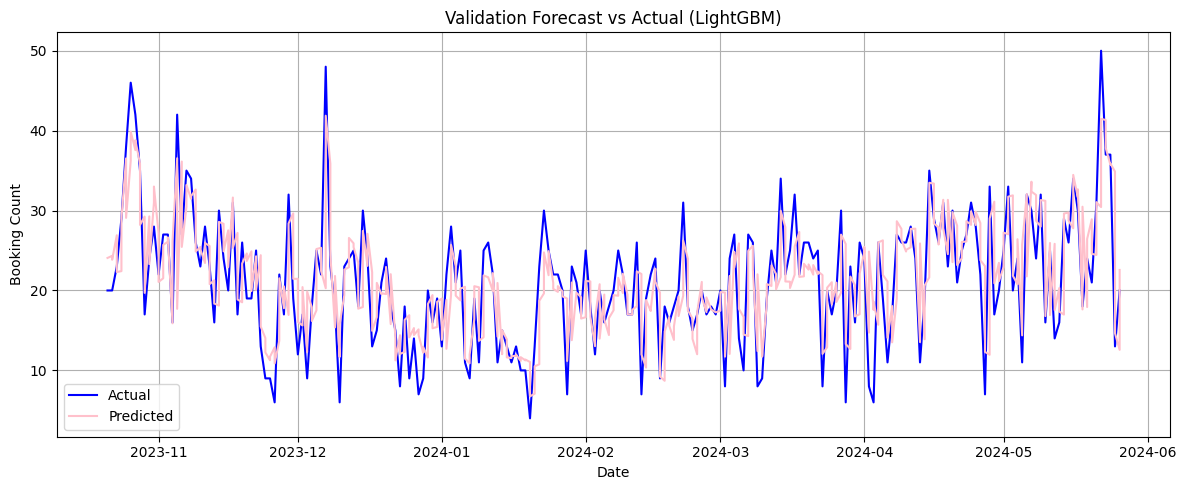

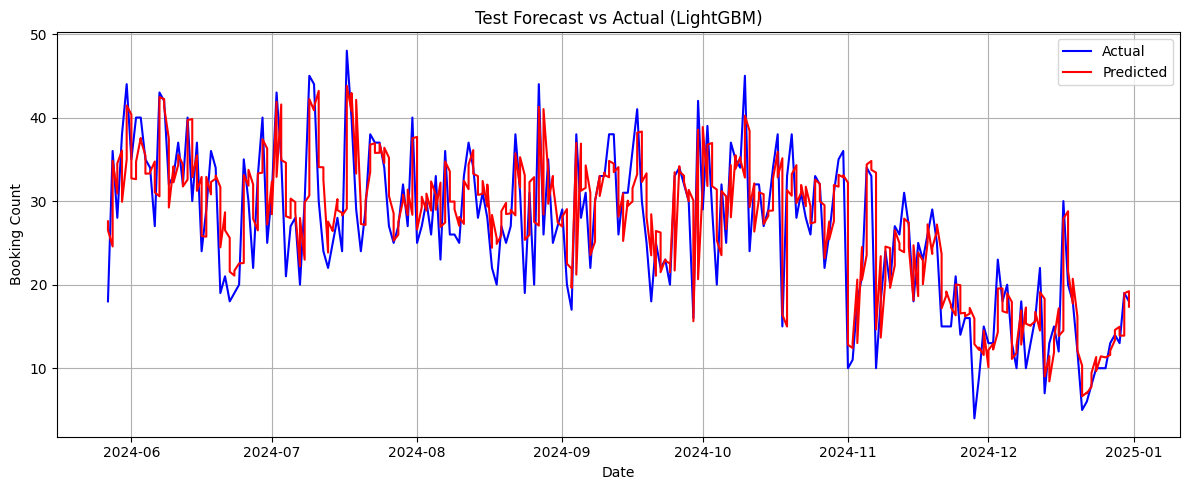

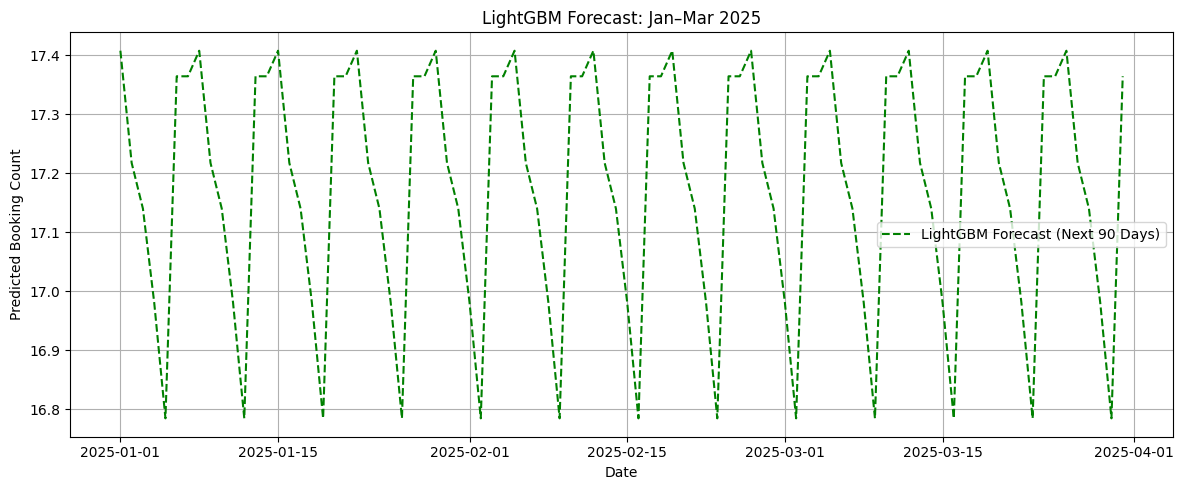

In [196]:
lgb = LGBMRegressor(random_state=42)

# Step 3: Grid Search
grid_search = GridSearchCV(lgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_lgb = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

# Step 4: Rename feature columns
X_val = X_val.rename(columns=rename_dict)
X_test = X_test.rename(columns=rename_dict)

# Step 5: Predictions
y_val_pred = best_lgb.predict(X_val)
y_test_pred = best_lgb.predict(X_test)

# Step 6: Evaluation function
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mse, mae, rmse, mape

# Step 7: Compute and display metrics
mse_val, mae_val, rmse_val, mape_val = compute_metrics(y_val, y_val_pred)
mse_test, mae_test, rmse_test, mape_test = compute_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    'MSE': [mse_val, mse_test],
    'MAE': [mae_val, mae_test],
    'RMSE': [rmse_val, rmse_test],
    'MAPE (%)': [mape_val, mape_test]
}, index=['Validation', 'Test'])

print("\n LightGBM Evaluation Metrics:")
display(metrics_df.round(2))

# Step 8: Validation Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(val['ds'], y_val.values, label='Actual', color='blue')
plt.plot(val['ds'], y_val_pred, label='Predicted', color='pink')
plt.title("Validation Forecast vs Actual (LightGBM)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Test Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(test['ds'], y_test.values, label='Actual', color='blue')
plt.plot(test['ds'], y_test_pred, label='Predicted', color='red')
plt.title("Test Forecast vs Actual (LightGBM)")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Generate 90-day Future Forecast
last_date = df_station['ds'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=90)

last_known_row = df_station.iloc[-1].copy()
future_data_lgb = []

for date in future_dates:
    new_row = last_known_row.copy()
    new_row['ds'] = date
    new_row['day_of_week'] = date.weekday()
    new_row['is_weekend'] = int(date.weekday() in [5, 6])

    X_future = pd.DataFrame([new_row])[feature_cols]
    X_future = X_future.rename(columns=rename_dict)
    new_row['y'] = best_lgb.predict(X_future)[0]

    future_data_lgb.append(new_row)
    last_known_row = new_row.copy()

df_future_lgb = pd.DataFrame(future_data_lgb)

# Step 11: Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(df_future_lgb['ds'], df_future_lgb['y'], label="LightGBM Forecast (Next 90 Days)", linestyle='--', color='green')
plt.title("LightGBM Forecast: Jan–Mar 2025")
plt.xlabel("Date")
plt.ylabel("Predicted Booking Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [154]:
import pandas as pd
import matplotlib.pyplot as plt

# Build results table
results = [
    {"Model": "Random Forest", "MAE": mae_rf, "MSE": mse_rf, "RMSE": rmse_rf, "MAPE": mape_rf},
    {"Model": "XGBoost",       "MAE": mae_xgb, "MSE": mse_xgb, "RMSE": rmse_xgb, "MAPE": mape_xgb},
    {"Model": "LightGBM",      "MAE": mae_lgb, "MSE": mse_lgb, "RMSE": rmse_lgb, "MAPE": mape_lgb},
    {"Model": "CatBoost",      "MAE": mae_cat, "MSE": mse_cat, "RMSE": rmse_cat, "MAPE": mape_cat}
]

df_results = pd.DataFrame(results).round(2)

# Identify the best model based on lowest RMSE
best_model_idx = df_results['RMSE'].idxmin()
best_model_name = df_results.loc[best_model_idx, 'Model']

# Highlight the best row
def highlight_best(s):
    return ['background-color: lightgreen' if i == best_model_idx else '' for i in range(len(s))]

# Show styled table
styled = df_results.style.apply(highlight_best, axis=0)
display(styled)

# Print winner
print(f"\n Best Model Based on RMSE: **{best_model_name}**")


,Model,MAE,MSE,RMSE,MAPE
0,Random Forest,3.950000,30.210000,5.500000,18.270000
1,XGBoost,4.460000,36.460000,6.040000,19.730000
2,LightGBM,4.090000,32.460000,5.700000,19.080000
3,CatBoost,4.030000,30.770000,5.550000,18.920000



 Best Model Based on RMSE: **Random Forest**


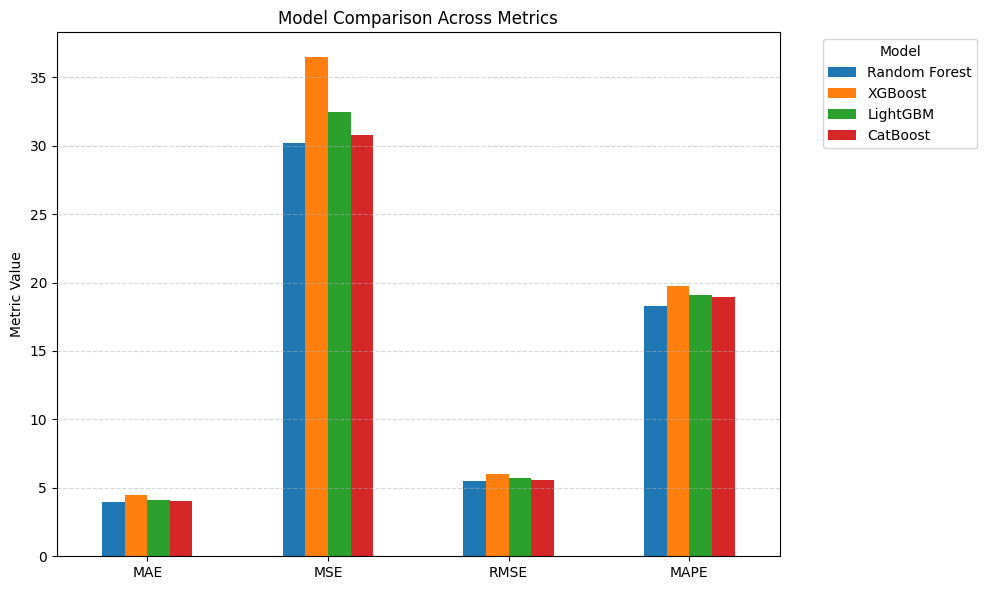

In [155]:
import matplotlib.pyplot as plt

# Transpose for easier plotting: models as X-axis, metrics as grouped bars
df_plot = df_results.set_index("Model").T

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars for each metric
df_plot.plot(kind='bar', ax=ax)

plt.title("Model Comparison Across Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


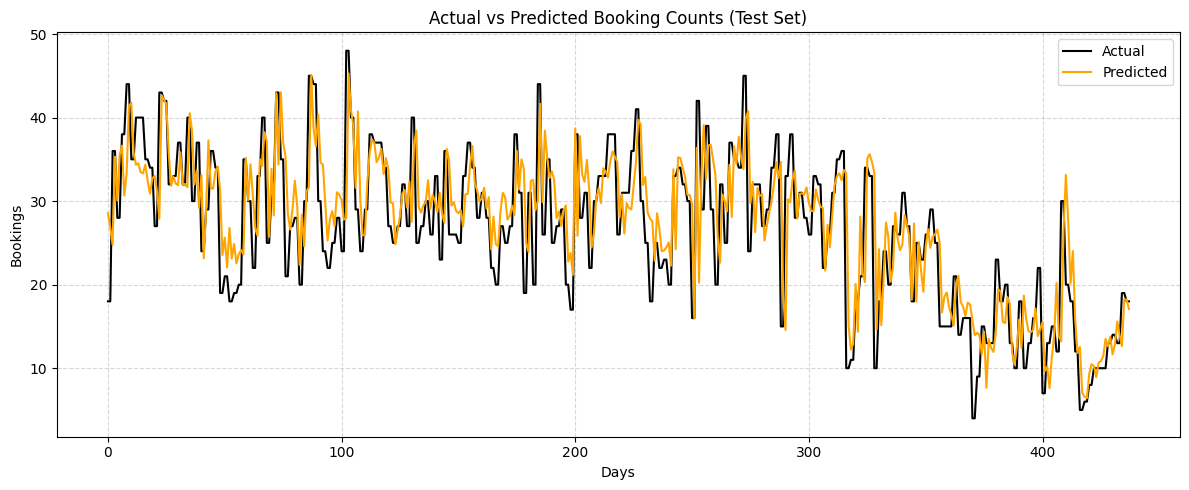

In [156]:
import matplotlib.pyplot as plt

# Predict using best model (CatBoost used as example)
best_model = cat_model
y_pred = best_model.predict(X_test)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual", color='black')
plt.plot(y_pred, label="Predicted", color='orange')
plt.title("Actual vs Predicted Booking Counts (Test Set)")
plt.xlabel("Days")
plt.ylabel("Bookings")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**Forecast Visualization**

Test Set Performance Comparison:


,MAE,MSE,RMSE,MAPE (%)
Random Forest,4.090000,32.270000,5.680000,18.830000
XGBoost,4.550000,38.490000,6.200000,21.170000
LightGBM,4.280000,33.720000,5.810000,19.660000
CatBoost,4.190000,33.320000,5.770000,19.660000



 The overall best-performing model is Random Forest, achieving the best score in 4 out of the 4 evaluated metrics: MAE, MSE, RMSE, and MAPE.


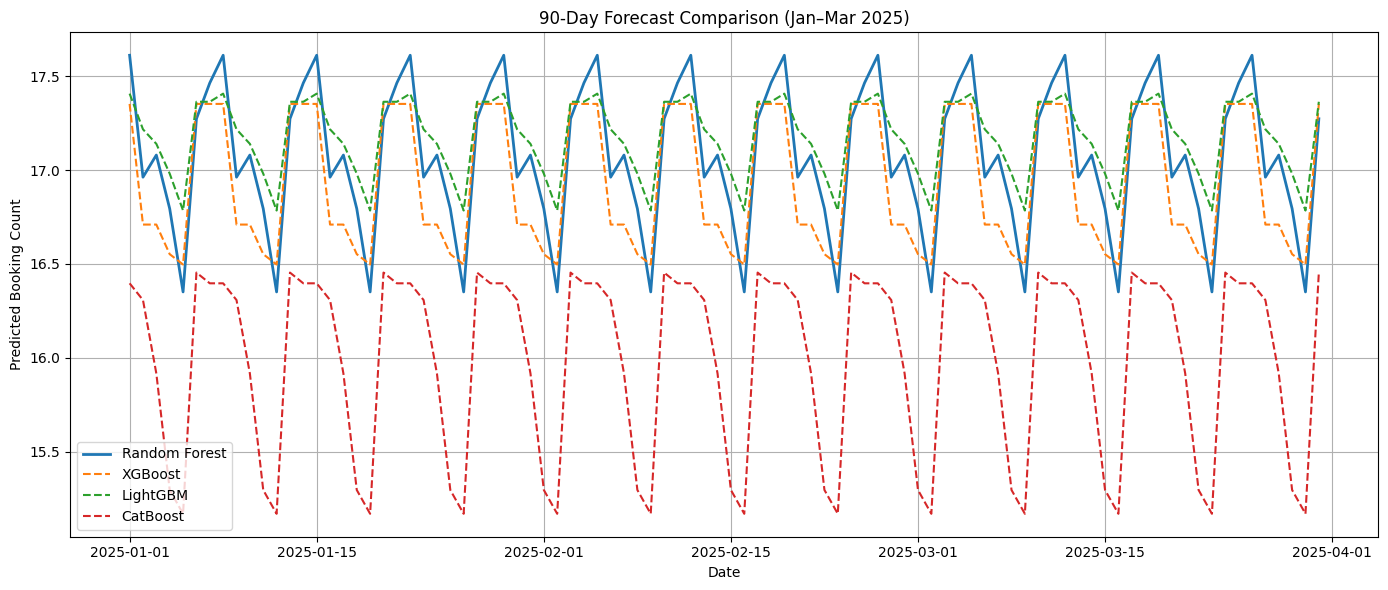

In [203]:
from IPython.display import display, Markdown
# Step 2: Predictions
y_pred_rf  = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_cat = cat_model.predict(X_test)

# Step 3: Metrics calculation function
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return [mae, mse, rmse, mape]

# Step 4: Compile results
results = {
    'Random Forest': get_metrics(y_test, y_pred_rf),
    'XGBoost': get_metrics(y_test, y_pred_xgb),
    'LightGBM': get_metrics(y_test, y_pred_lgb),
    'CatBoost': get_metrics(y_test, y_pred_cat),
}

df_results = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'MAPE (%)']).T.round(2)

# Step 5: Highlight minimum values
styled_df = df_results.style.highlight_min(axis=0, color='lightgreen', props='font-weight: bold')

# Step 6: Display table and identify best model
print("Test Set Performance Comparison:")
display(styled_df)

best_counts = df_results.idxmin().value_counts()
overall_best = best_counts.idxmax()

print(f"\n The overall best-performing model is {overall_best}, achieving the best score in {best_counts[overall_best]} out of the 4 evaluated metrics: MAE, MSE, RMSE, and MAPE.")

plt.figure(figsize=(14, 6))
plt.plot(df_future_rf['ds'], df_future_rf['y'], label='Random Forest', linewidth=2)
plt.plot(df_future_xgb['ds'], df_future_xgb['y'], label='XGBoost', linestyle='--')
plt.plot(df_future_lgb['ds'], df_future_lgb['y'], label='LightGBM', linestyle='--')
plt.plot(df_future_cat['ds'], df_future_cat['y'], label='CatBoost', linestyle='--')

plt.title("90-Day Forecast Comparison (Jan–Mar 2025)")
plt.xlabel("Date")
plt.ylabel("Predicted Booking Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


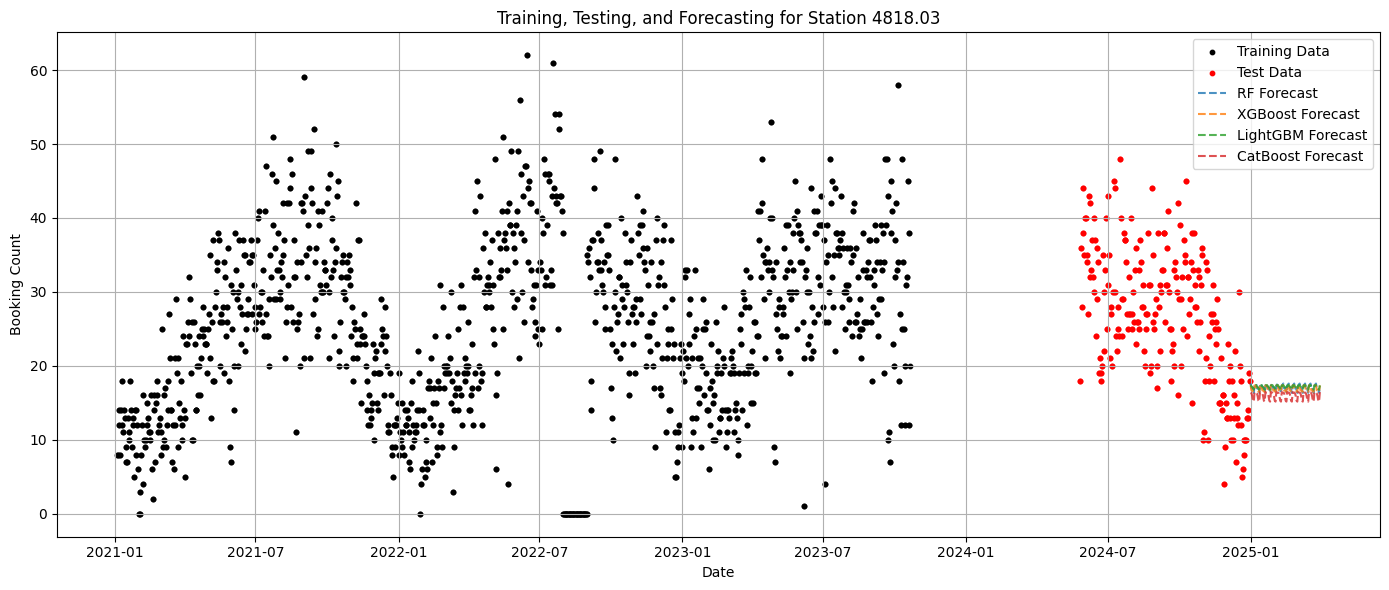

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot training and test data
plt.scatter(train['ds'], train['y'], color='black', label='Training Data', s=10)
plt.scatter(test['ds'], test['y'], color='red', label='Test Data', s=10)

# Plot forecast lines for each model
plt.plot(df_future_rf['ds'], df_future_rf['y'], label='RF Forecast', linestyle='--', alpha=0.8)
plt.plot(df_future_xgb['ds'], df_future_xgb['y'], label='XGBoost Forecast', linestyle='--', alpha=0.8)
plt.plot(df_future_lgb['ds'], df_future_lgb['y'], label='LightGBM Forecast', linestyle='--', alpha=0.8)
plt.plot(df_future_cat['ds'], df_future_cat['y'], label='CatBoost Forecast', linestyle='--', alpha=0.8)

# Labels and title
plt.title('Training, Testing, and Forecasting for Station 4818.03')
plt.xlabel('Date')
plt.ylabel('Booking Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Conclusion** :This analysis demonstrates the effectiveness of ensemble models for short-term bike demand forecasting. Random Forest performed best overall, showing strong generalization and low prediction error.
